In [1]:
%matplotlib widget
import sympy

from sympy import cos, ln, Matrix, sin, symbols

sympy.init_printing()

In [32]:
class Equilibrium:
    from sympy.abc import alpha, delta, epsilon, kappa, tau, X, Y

    Ui = [
        1,
        X ** 2,
        Y ** 2 - X ** 2 * ln(X),
        X ** 4 - 4 * X ** 2 * Y ** 2,
        2 * Y ** 4 - 9 * Y ** 2 * X ** 2 - (12 * Y ** 2 * X ** 2 - 3 * X ** 4) * ln(X),
        X ** 6 - 12 * X ** 4 * Y ** 2 + 8 * X ** 2 * Y ** 4,
        8 * Y ** 6
        - 140 * Y ** 4 * X ** 2
        + 75 * Y ** 2 * X ** 4
        - (120 * Y ** 4 * X ** 2 - 180 * Y ** 2 * X ** 4 + 15 * X ** 6) * ln(X),
    ]

    c = symbols(f"c_0:{len(Ui)}")

    U = alpha * X ** 2 * ln(X) + (1 - alpha) / 8 * X ** 4 + Matrix(Ui).dot(c)

    Xref = 1 + epsilon * cos(tau + delta * sin(tau))

    Yref = epsilon * kappa * sin(tau)
    curve = sympy.Matrix([eq.Xref, eq.Yref])

    outer_point = {X: 1 + epsilon, Y: 0}
    inner_point = {X: 1 - epsilon, Y: 0}
    high_point = {X: 1 - delta * epsilon, Y: kappa * epsilon}
    N1 = +((1 + delta) ** 2) / (epsilon * kappa ** 2)
    N2 = -((1 - delta) ** 2) / (epsilon * kappa ** 2)
    N3 = -kappa / (epsilon * cos(delta) ** 2)

    equations_6_155 = [
        U.subs(outer_point),
        (U.diff(Y, 2) + N1 * U.diff(X)).subs(outer_point),
        U.subs(inner_point),
        (U.diff(Y, 2) + N2 * U.diff(X)).subs(inner_point),
        U.subs(high_point),
        U.diff(X).subs(high_point),
        (U.diff(X, 2) + N3 * U.diff(Y)).subs(high_point),
    ]

    Amatrix, bvector = sympy.linear_eq_to_matrix(equations_6_155, c)

    def symbolic_equilibrium(self, alpha, delta, epsilon, kappa):
        # TODO lambdify should not be in the function itself; but I couldn't get it to work
        Afunc = sympy.lambdify((self.delta, self.epsilon, self.kappa), self.Amatrix)
        Bfunc = sympy.lambdify(
            (self.alpha, self.delta, self.epsilon, self.kappa), self.bvector
        )
        A = Afunc(delta, epsilon, kappa)
        b = Bfunc(alpha, delta, epsilon, kappa)
        c = np.linalg.solve(A, b)
        U_substitutions = dict(zip(eq.c, c.squeeze()))
        return eq.U.subs(U_substitutions)


eq = Equilibrium()

In [33]:
JET = dict(
    R_0=3,
    a=1,
    epsilon=1 / 3,
    kappa=1.7,
    delta=0.25,
    B_0=3.6,
    I=4,
    qstar=2.7,
    beta_t=0.03,
)
JET_geometry = dict(epsilon=JET["epsilon"], kappa=JET["kappa"], delta=JET["delta"],)

{'epsilon': 0.3333333333333333, 'kappa': 1.7, 'delta': 0.25}

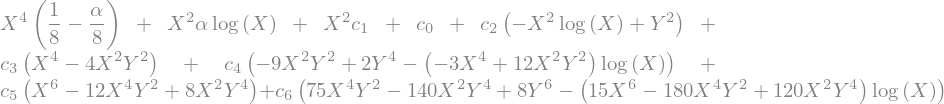

In [34]:
eq.U

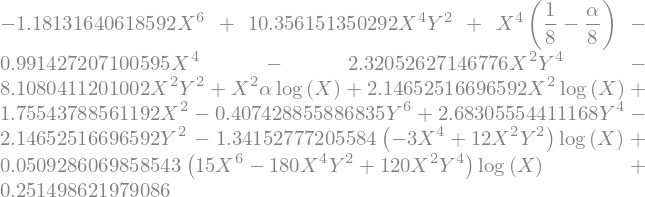

In [35]:
symeq = eq.symbolic_equilibrium(alpha=0.1, **JET_geometry)

In [36]:
symeqfunc = sympy.lambdify((eq.X, eq.Y, eq.alpha), symeq)
symeqfunc(0.1, 0, 0.1)

In [38]:
eq.Xref, eq.Yref

In [41]:
coordinates = sympy.lambdify((eq.epsilon, eq.tau, eq.delta, eq.kappa), eq.curve)

<function _lambdifygenerated(epsilon, tau, delta, kappa)>

In [46]:
from ipywidgets import fixed, FloatSlider, interact, interact_manual, interactive


def plot(alpha):
    curve_x, curve_y = sympy.lambdify(eq.tau, eq.curve.subs(JET_geometry))(
        np.linspace(0, 2 * np.pi, 500)
    ).squeeze()
    factor = 1
    X, Y = np.meshgrid(
        np.linspace(curve_x.min() / factor, curve_x.max() * factor, 600),
        np.linspace(curve_y.min() * factor, curve_y.max() * factor, 500),
        indexing="ij",
    )
    symeq = eq.symbolic_equilibrium(alpha=alpha, **JET_geometry)
    symeqfunc = sympy.lambdify((eq.X, eq.Y, eq.alpha), symeq)
    values = symeqfunc(X, Y, alpha)

    fig, ax = plt.subplots()
    #     contours_color = ax.contourf(X, Y, values, levels=50)
    contours = ax.contour(X, Y, values, levels=50)
    ax.plot(curve_x, curve_y)
    plt.colorbar(contours)
    plt.title(f"{alpha=}")
    plt.show()


interactive_plot = interactive(plot, alpha=(0, 1.0))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

In [47]:
plot(alpha=0.1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
plot(alpha=0.9)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
plot(alpha=30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
plot(alpha=10000)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
# sympy.plotting.plot_parametric(
#     *(
#     [(Xjet.subs(eq.epsilon, eps), Yjet.subs(epsilon, eps)) for eps in np.linspace(0, float(JET[epsilon]), 10)] +
#     [(-Xjet.subs(eq.epsilon, eps), Yjet.subs(epsilon, eps)) for eps in np.linspace(0, float(JET[epsilon]), 10)])
# )

In [13]:
%timeit symeq = eq.symbolic_equilibrium(alpha=0.1, **JET_geometry)

110 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
eq = Equilibrium()
symeq = eq.symbolic_equilibrium(alpha=0.1, **JET_geometry)

107 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Trash is below here

In [14]:
A, C, R_0 = symbols("A C R_0")
psi_0, B_0 = symbols("psi_0 B_0")
from sympy.abc import a, I

qstar = symbols("q_*")

beta_t, beta_p = symbols("beta_t beta_p")

In [15]:
{alpha: A / (A + C * R_0 ** 2), psi_0: R_0 ** 2 * (A + C * R_0 ** 2)}

NameError: name 'alpha' is not defined

In [ ]:
# qstar = kink safety factor
inverse_qstar = 1 / (2 * pi) * 2 / (1 + kappa ** 2) * (psi_0) / (a ** 2 * B0) * K1

In [ ]:
XJET = Xref.subs(JET)
YJET = Yref.subs(JET)

In [ ]:
U.subs({X: Xref, Y: Yref}).subs({kappa: 1.7, delta: 0.25})

In [ ]:
Xref.subs(JET)

In [ ]:
Xjet = Xref.subs({delta: JET[delta], kappa: JET[kappa]})
Yjet = Yref.subs({delta: JET[delta], kappa: JET[kappa]})

In [ ]:
plotting.plot_parametric(
    *(
        [
            (Xjet.subs(epsilon, eps), Yjet.subs(epsilon, eps))
            for eps in np.linspace(0, float(JET[epsilon]), 10)
        ]
        + [
            (-Xjet.subs(epsilon, eps), Yjet.subs(epsilon, eps))
            for eps in np.linspace(0, float(JET[epsilon]), 10)
        ]
    )
)

In [ ]:
XJET = Xref.subs(JET)
YJET = Yref.subs(JET)
TFTR = {epsilon: 1 / 2.9, kappa: 1, delta: 0}
XTFTR = Xref.subs(TFTR)
YTFTR = Yref.subs(TFTR)
plotting.plot_parametric(
    (XJET, YJET), (-XJET, YJET), (XTFTR, YTFTR), (-XTFTR, YTFTR),
)

In [ ]:
plotting.plot_parametric(Xref.subs(JET), Yref.subs(JET))

In [ ]:
jacobian = Matrix([Xref, Yref]).jacobian([epsilon, tau]).det().simplify()

In [ ]:
jacobian * Xref

In [ ]:
epsilon_i = epsilon.as_dummy()

In [ ]:
integrands = [
    (alpha + (1 - alpha) * Xref ** 2) / X,
    -U.subs({X: Xref, Y: Yref}) * Xref,
    Xref,
]

In [ ]:
K = [
    integrate(
        (jacobian * integrand).subs(epsilon, epsilon_i).simplify(),
        (epsilon_i, 0, epsilon),
        (tau, 0, 2 * pi),
    )
    for integrand in integrands
]

In [ ]:
K1, K2, K3 = symbols("K_1:4")

In [ ]:
inverse_qstar = 1 / (2 * pi) * 2 / (1 + kappa ** 2) * psi_0 / (a ** 2 * B_0) * K1

In [ ]:
qstar_eq = Eq(1 / qstar, inverse_qstar)

In [ ]:
beta_p_eq = Eq(
    8
    * pi ** 2
    * epsilon ** 2
    * (1 - alpha)
    * (1 + kappa ** 2)
    / 2
    * (K2 / K3 / K1 ** 2),
    beta_p,
)

In [ ]:
beta_t_eq = Eq(
    (8 * pi ** 2 * epsilon ** 4 * (1 - alpha))
    * inverse_qstar ** 2
    * ((1 + kappa ** 2) / 2) ** 2
    * K2
    / K3
    / K1 ** 2,
    beta_t,
)

In [ ]:
psi0_solution = solve(qstar_eq, psi_0)[0]

In [ ]:
beta_p

In [ ]:
Eq(alpha, A / (A + C * R_0 ** 2))

In [ ]:
result.subs(geometry).evalf()

In [ ]:
integrate(alpha + (1 - alpha) * X ** 2) / X

In [ ]:
integrate(X, (X, -Xref, Xref), (Y, -Yref, Yref))